# **Predicting benefits nonclaimants in Canada with machine learning methods**

Ian Scott /
ECON 882 /
April 30th, 2025

## **Introduction**

In the 2019 tax year the Government of Canada transitioned the Workers Income Tax Benefit (WITB) to the Canadian Income Benefit (CIB). This low income tax benefit incentivizes workers to join the workforce by provides transfers for Canadians within a range of low incomes. Students are not eligible for the benefit. The transtion from WITB to CIB increased the amount Canadians received and expanded eligibility. One key change was that tax filers were now automatically assessed for qualifications. The WITB had needed additional paperwork to apply for. Because of this, there was a large number of eligible non-claimants. This did not seem to be random, as the share by province varied substantially. My project will train machine learning models to identify non-claimants. I will use and compare a variety of methods.

## **Data**

I will use the Canadian Income Survey (CIS) Public Use Microdata File (PUMF) to conduct my analysis. I use the years 2012 to 2018, all available years of the dataset where the WITB was in effect. The CIS is an annual survey that collects additional information on individual and family income dynamics from a subset of Labour Force Survey respondents. My sample includes 477,597 observations and 212 variables. 

I identify those eligible for the WITB through their reported age groups, student status, and incomes. I use the annual range of WITB eligibility values to compute a binary variable which indicates eligibility. The WITB was only eligible to those 19+ but given the age bands in the CIS datatset I was only able to identify those under 18. Excluding the band with 18 year olds would throw out observations of 19-24 year olds which is costly. A majority of that age group is students, so I have limited concerns about the impact a small number of 18 year olds will have on the overall validity of my results. I cut my sample down to those who are eligible for the WITB, which reduces the number of observations to 42,210.

I identify WITB receivership through the "other government transfers" (OGOVTR) variable. This includes other benefits than the WITB. A non-claimant could foreseeably recieve the another benefit, not the WITB, and falsely be included in the non-claimant group. This is an issue with my data that cannot easily be remdied. Much as with the age variable, I have achieved as close an identification as possible. Calculating the exact eligible WITB amount for observations would not be possible with my dataset, so is not a possible remedy.

A number of variables have swathes of NA values. I remove variables with NAs. This leaves me with 161 variables, which is still rich. The difference between this and a 5% tolerance for NA values is 3 variables, which is only a marginal loss in granularity.

## **Splitting the data**

In [100]:
# Import data
data <- read.csv("882_data.csv")

# Loading Libraries
library(tidyverse)
library(rsample)
library(rpart)
library(Metrics)
library(mgcv)
library(xgboost)
library(randomForest)
library(tree)
library(splines)
library(grf)
library(leaps)
library(dplyr)
library(caret)
library(glmnet)
library(fastDummies)
library(rpart.plot)
library(pROC)

# Remove variables with missing values
data <- data[, colMeans(is.na(data)) == 0]


In [101]:
### Splitting the data in to training and testing sets

# Set the seed for a random split
set.seed(123)

#Split the data into training and testing sets
df_split = initial_split(data = data, prop = 0.7)
df_train = training(df_split)
df_test = testing(df_split)

In [102]:
### Naive models

# Linear model
ols_model <- lm(nonrec ~ earng + efeipr + efinva + factor(mbmregp) + factor(uszgap) + factor(agegp) + factor(fllprtp) + factor(cmphi) + factor(alfst) + factor(eftyp), data = df_train)

# Compute RMSE
resids <- residuals(ols_model)
rmse <- sqrt(mean(resids^2))
cat("The RMSE from the linear regression model is", rmse)

#Confusion matrix for probit model
ols_pred5 <- predict(ols_model,df_test)
ols_pred5 <- ifelse(ols_pred5 > 0.5,1,0)
confusionMatrix(as.factor(ols_pred5),as.factor(df_test$nonrec))

#Confusion matrix for probit model
ols_pred2 <- predict(ols_model,df_test)
ols_pred2 <- ifelse(ols_pred2 > 0.2,1,0)
confusionMatrix(as.factor(ols_pred2),as.factor(df_test$nonrec))

cat("Even though RMSE is better, the accuracy of the OLS model is lower than that of the probit model, though not by much. With a probability threshold of 50% the model tends to predict a gargantuan proportion of values will be non-recipients which is unrealistic. The OLS model generates fewer false negatives, but more false positives.
")

# Logit model
logit_model <- glm(nonrec ~ earng + efeipr + efinva + factor(mbmregp) + factor(uszgap) + factor(agegp) + factor(fllprtp) + factor(cmphi) + factor(alfst) + factor(eftyp), data = df_train, family = "binomial")

# Compute RMSE
actual <- df_train$nonrec
pred_probs <- predict(logit_model, type = "response")
rmse <- sqrt(mean((pred_probs - actual)^2))
cat(". The RMSE from the probit regression model is", rmse, "Linear regression seems to have a closer prediction.")

#Confusion matrix for probit model
glm_pred5 <- predict(logit_model,df_test)
glm_pred5 <- ifelse(glm_pred5 > 0.5,1,0)
confusionMatrix(as.factor(glm_pred5),as.factor(df_test$nonrec))

#Confusion matrix for probit model
glm_pred2 <- predict(logit_model,df_test)
glm_pred2 <- ifelse(glm_pred2 > 0.2,1,0)
confusionMatrix(as.factor(glm_pred2),as.factor(df_test$nonrec))

cat("Probit: Switching from a 50% cutoff to a 20% cutoff increases accuracy but increases the number of false positives. Results are also more sensitive.")

The RMSE from the linear regression model is 0.3897111

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1792  786
         1 1931 8155
                                          
               Accuracy : 0.7855          
                 95% CI : (0.7782, 0.7926)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.4322          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4813          
            Specificity : 0.9121          
         Pos Pred Value : 0.6951          
         Neg Pred Value : 0.8085          
             Prevalence : 0.2940          
         Detection Rate : 0.1415          
   Detection Prevalence : 0.2036          
      Balanced Accuracy : 0.6967          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  309   87
         1 3414 8854
                                          
               Accuracy : 0.7235          
                 95% CI : (0.7157, 0.7313)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : 6.967e-06       
                                          
                  Kappa : 0.0991          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.08300         
            Specificity : 0.99027         
         Pos Pred Value : 0.78030         
         Neg Pred Value : 0.72172         
             Prevalence : 0.29398         
         Detection Rate : 0.02440         
   Detection Prevalence : 0.03127         
      Balanced Accuracy : 0.53663         
                                          
       'Positive' Class : 0               
                        

Even though RMSE is better, the accuracy of the OLS model is lower than that of the probit model, though not by much. With a probability threshold of 50% the model tends to predict a gargantuan proportion of values will be non-recipients which is unrealistic. The OLS model generates fewer false negatives, but more false positives.
. The RMSE from the probit regression model is 0.3860098 Linear regression seems to have a closer prediction.

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2403 1446
         1 1320 7495
                                          
               Accuracy : 0.7816          
                 95% CI : (0.7743, 0.7888)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.479           
                                          
 Mcnemar's Test P-Value : 0.01747         
                                          
            Sensitivity : 0.6454          
            Specificity : 0.8383          
         Pos Pred Value : 0.6243          
         Neg Pred Value : 0.8503          
             Prevalence : 0.2940          
         Detection Rate : 0.1898          
   Detection Prevalence : 0.3039          
      Balanced Accuracy : 0.7419          
                                          
       'Positive' Class : 0               
                        

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2088 1042
         1 1635 7899
                                          
               Accuracy : 0.7886          
                 95% CI : (0.7814, 0.7957)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.466           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5608          
            Specificity : 0.8835          
         Pos Pred Value : 0.6671          
         Neg Pred Value : 0.8285          
             Prevalence : 0.2940          
         Detection Rate : 0.1649          
   Detection Prevalence : 0.2472          
      Balanced Accuracy : 0.7221          
                                          
       'Positive' Class : 0               
                        

Probit: Switching from a 50% cutoff to a 20% cutoff increases accuracy but increases the number of false positives. Results are also more sensitive.

In [103]:
# List of categorical variables to be converted to dummies
categorical_vars <- c("prov", "uszgap", "mbmregp", "agegp", "sex", "marstp", "cmphi", 
                      "hlev2g", "studtfp", "fllprtp", "fworked", "scsum", "alfst", 
                      "wksem", "wksuem", "wksnlf", "fpdwk", "fsemp", "funfw", 
                      "immst", "yrimmg", "majri", "eftyp", "efmjieh", "efrmjig", 
                      "efagofmp", "efagyfmp", "hhcomp", "hhmj ie", "licofa", 
                      "licofb", "limsfa", "mbscf18", "dwltyp", "dwtenr", "repa", 
                      "suit", "mortg", "rnsub", "chneed", "fscadltm", "fscchldm", "fschhldm")

# Create dummies safely without model.matrix()
df_train2 <- fastDummies::dummy_cols(df_train, select_columns = categorical_vars, remove_first_dummy = FALSE, remove_selected_columns = TRUE)
df_test2  <- fastDummies::dummy_cols(df_test,  select_columns = categorical_vars, remove_first_dummy = FALSE, remove_selected_columns = TRUE)


Warning message in fastDummies::dummy_cols(df_train, select_columns = categorical_vars, :
"NOTE: The following select_columns input(s) is not a column in data.
	"
Warning message in fastDummies::dummy_cols(df_test, select_columns = categorical_vars, :
"NOTE: The following select_columns input(s) is not a column in data.
	"


In [104]:
### Elastic Net

# Split into dummied training and testing sets
X_train <- as.matrix(df_train2[, setdiff(names(df_train2), "nonrec")])
y_train <- df_train2$nonrec

X_test <- as.matrix(df_test2[, setdiff(names(df_test2), "nonrec")])
y_test <- df_test2$nonrec

# Fit Elastic Net (alpha = 0.5 for compromise between ridge and lasso)
# Note: R will automatically factor categorical variables and glmnet will automatically standardize predictors (see documentation)
cv_model <- cv.glmnet(X_train, y_train, family = "binomial", alpha = 0.5, nfolds = 100)

# Predict on test data using best lambda
pred_probs <- predict(cv_model, newx = X_test, type = "response", s = "lambda.min")

# Compute RMSE
rmse <- sqrt(mean((pred_probs - y_test)^2))
print(rmse)

[1] 0.2839805


In [105]:
elastic_pred <- pred_probs
elastic_pred <- ifelse(elastic_pred > 0.5,1,0)
confusionMatrix(as.factor(elastic_pred),as.factor(df_test$nonrec))

cat("A cutoff of 80% is actually the most accurate. However, lower cutoffs have lower (0) false negatives which is a reduction from 5 in elastic net. Thid id s tradeoff for a thirding of the fall positives from 224 to 71. This shows that the elastic net model works well, and can perform well on out of sample data.")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2925  607
         1  798 8334
                                          
               Accuracy : 0.8891          
                 95% CI : (0.8835, 0.8945)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7287          
                                          
 Mcnemar's Test P-Value : 4.001e-07       
                                          
            Sensitivity : 0.7857          
            Specificity : 0.9321          
         Pos Pred Value : 0.8281          
         Neg Pred Value : 0.9126          
             Prevalence : 0.2940          
         Detection Rate : 0.2310          
   Detection Prevalence : 0.2789          
      Balanced Accuracy : 0.8589          
                                          
       'Positive' Class : 0               
                        

A cutoff of 80% is actually the most accurate. However, lower cutoffs have lower (0) false negatives which is a reduction from 5 in elastic net. Thid id s tradeoff for a thirding of the fall positives from 224 to 71. This shows that the elastic net model works well, and can perform well on out of sample data.

Optimal lambda (lambda.min): 4.226521e-05 
Binomial deviance at lambda.min: 0.5537137 
Largest lambda within 1SE of optimal lambda (lambda1se): 0.0001290719 
Binomial deviance at lambda1se: 0.5598661 


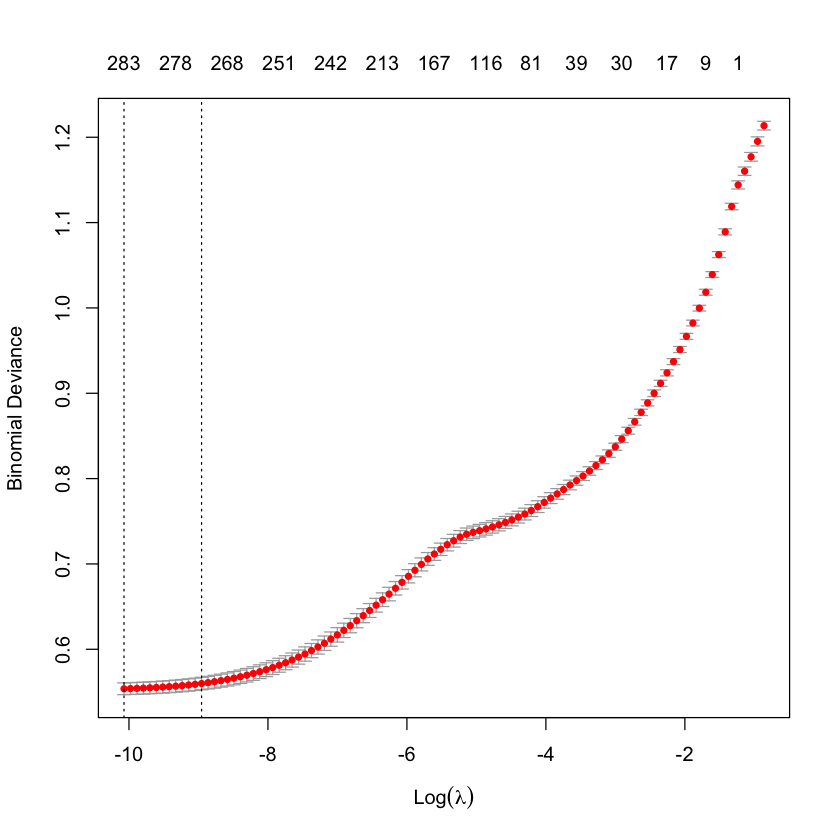

In [106]:
#### Plots and lambda values for the elastic net model
lambda_opt <- cv_model$lambda.min
lambda1se <- cv_model$lambda.1se
lambda_min_index <- which(cv_model$lambda == lambda_opt)
lambda_1se_index <- which(cv_model$lambda == lambda1se)
binomial_dev_min <- cv_model$cvm[lambda_min_index]
binomial_dev_1se <- cv_model$cvm[lambda_1se_index]

# Print results
cat("Optimal lambda (lambda.min):", lambda_opt, "\n")
cat("Binomial deviance at lambda.min:", binomial_dev_min, "\n")
cat("Largest lambda within 1SE of optimal lambda (lambda1se):", lambda1se, "\n")
cat("Binomial deviance at lambda1se:", binomial_dev_1se, "\n")
lmin = cv_model$lambda.min
l1se = cv_model$lambda.1se
plot(cv_model)


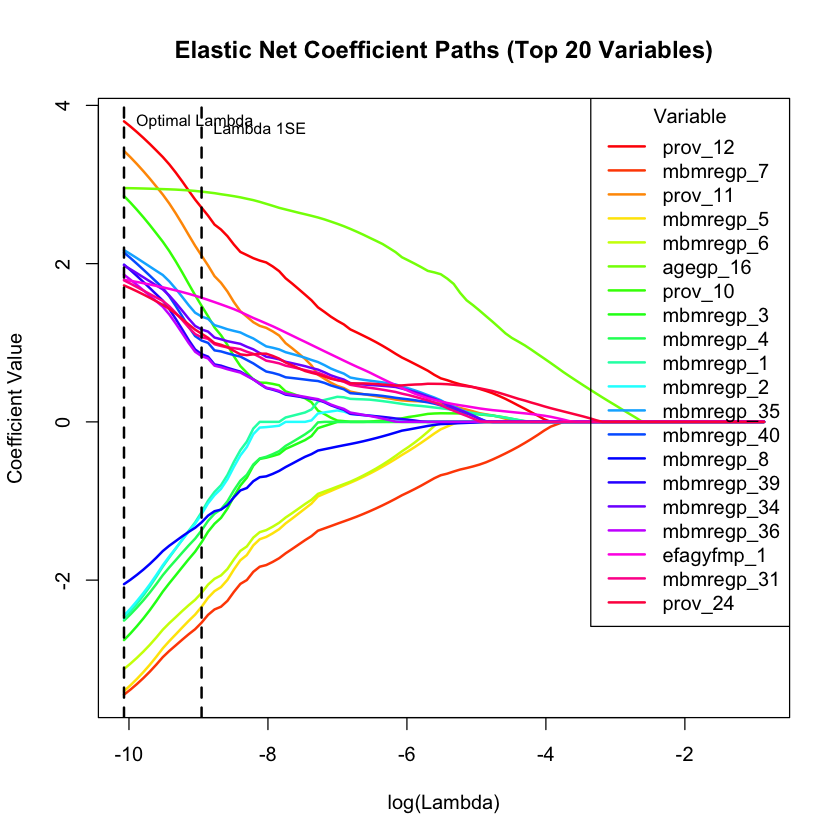

In [107]:
# Extract coefficient matrix and lambda values
coef_matrix <- as.matrix(cv_model$glmnet.fit$beta)
lambda_vals <- cv_model$glmnet.fit$lambda

# Find coefficients at lambda.min
coef_at_lambda_min <- as.numeric(coef(cv_model, s = "lambda.min"))[-1] # drop intercept

# Select top 20 variables by absolute value
top20_indices <- order(abs(coef_at_lambda_min), decreasing = TRUE)[1:20]
top20_vars <- rownames(coef_matrix)[top20_indices]

# Assign colours
num_vars <- length(top20_vars)
colors <- rainbow(num_vars)

# Create the base plot
plot(log(lambda_vals), coef_matrix[top20_indices[1], ], type = "l",
     col = colors[1], lwd = 2, xlab = "log(Lambda)", ylab = "Coefficient Value",
     main = "Elastic Net Coefficient Paths (Top 20 Variables)",
     ylim = range(coef_matrix[top20_indices, ]),
     xlim = c(min(log(lambda_vals)), max(log(lambda_vals))))  

# Add remaining coefficient paths
for (i in 2:num_vars) {
  lines(log(lambda_vals), coef_matrix[top20_indices[i], ], col = colors[i], lwd = 2)
}

# Add a legend
legend("topright", legend = top20_vars, col = colors, lty = 1, lwd = 2, title = "Variable")

# Add vertical lines and annotations for optimal lambdas
abline(v = log(lmin), col = "black", lty = 2, lwd = 2)
text(log(lmin), max(coef_matrix[top20_indices, ]), labels = "Optimal Lambda", pos = 4, cex = 0.8, col = "black")

abline(v = log(l1se), col = "black", lty = 2, lwd = 2)
text(log(l1se), max(coef_matrix[top20_indices, ] - 0.1), labels = "Lambda 1SE", pos = 4, cex = 0.8, col = "black")


In [108]:
### Random Forest

# 5-fold cross-validation
set.seed(123)
folds <- createFolds(y_train, k = 5)

# Grid of mtry values to try
mtry_grid <- 1:3
cv_results <- data.frame(mtry = mtry_grid, avg_accuracy = NA)

for (m in mtry_grid) {
  acc_folds <- c()
  
  for (fold in folds) {
    # Split data
    X_tr <- X_train[-fold, , drop = FALSE]
    y_tr <- y_train[-fold]
    X_val <- X_train[fold, , drop = FALSE]
    y_val <- y_train[fold]
    
    # Train random forest (classification)
    rf <- randomForest(x = X_tr, y = as.factor(y_tr), mtry = m, ntree = 100)
    
    # Predict on validation set
    preds <- predict(rf, X_val, type = "response")
    
    # Accuracy
    acc <- mean(preds == y_val)
    acc_folds <- c(acc_folds, acc)
  }
  
  # Store average accuracy
  cv_results$avg_accuracy[cv_results$mtry == m] <- mean(acc_folds)
}

# Show cross-validation results
print(cv_results)


  mtry avg_accuracy
1    1    0.7840643
2    2    0.8233265
3    3    0.8194341


In [109]:
## Confusio matrix and variable importance chart

best_mtry <- cv_results$mtry[which.max(cv_results$avg_accuracy)]
cat("Best mtry:", best_mtry, "\n")

best_rf_model <- randomForest(x = X_train, y = as.factor(y_train), mtry = best_mtry, ntree = 100)



Best mtry: 2 


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2469  968
         1 1254 7973
                                          
               Accuracy : 0.8245          
                 95% CI : (0.8178, 0.8311)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5676          
                                          
 Mcnemar's Test P-Value : 1.484e-09       
                                          
            Sensitivity : 0.6632          
            Specificity : 0.8917          
         Pos Pred Value : 0.7184          
         Neg Pred Value : 0.8641          
             Prevalence : 0.2940          
         Detection Rate : 0.1950          
   Detection Prevalence : 0.2714          
      Balanced Accuracy : 0.7775          
                                          
       'Positive' Class : 0               
                        

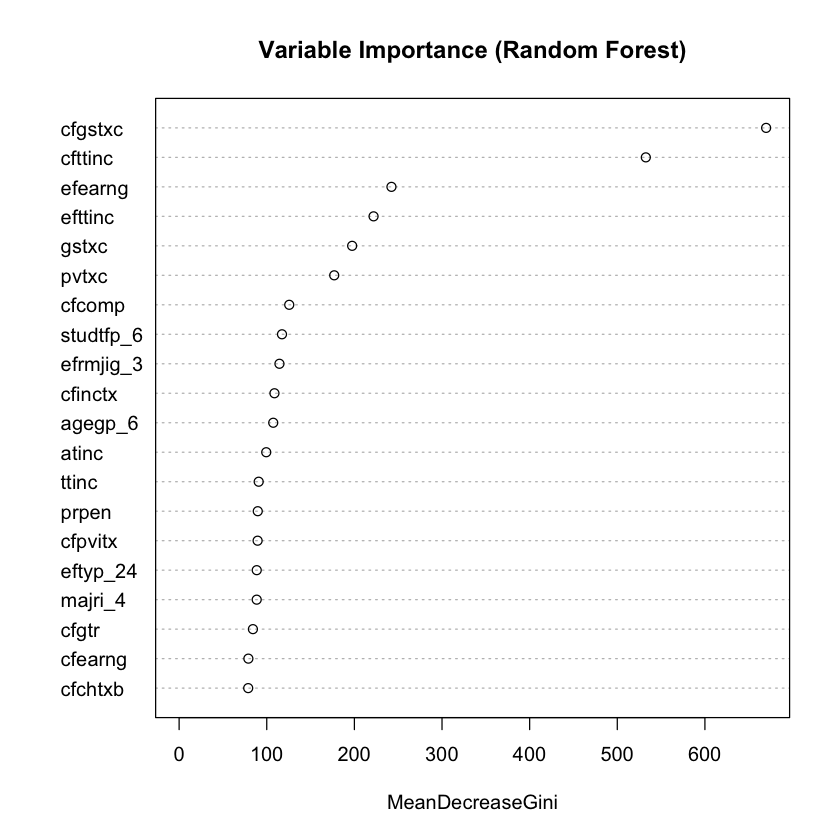

In [110]:
rf_preds <- predict(best_rf_model, X_test, type = "response")
conf_matrix <- confusionMatrix(rf_preds, as.factor(y_test))
print(conf_matrix)

# Plot variable importance
varImpPlot(best_rf_model,
           type = 2,  # type = 2 for Mean Decrease Gini
           main = "Variable Importance (Random Forest)",
           n.var = 20)  # Show top 20 variables

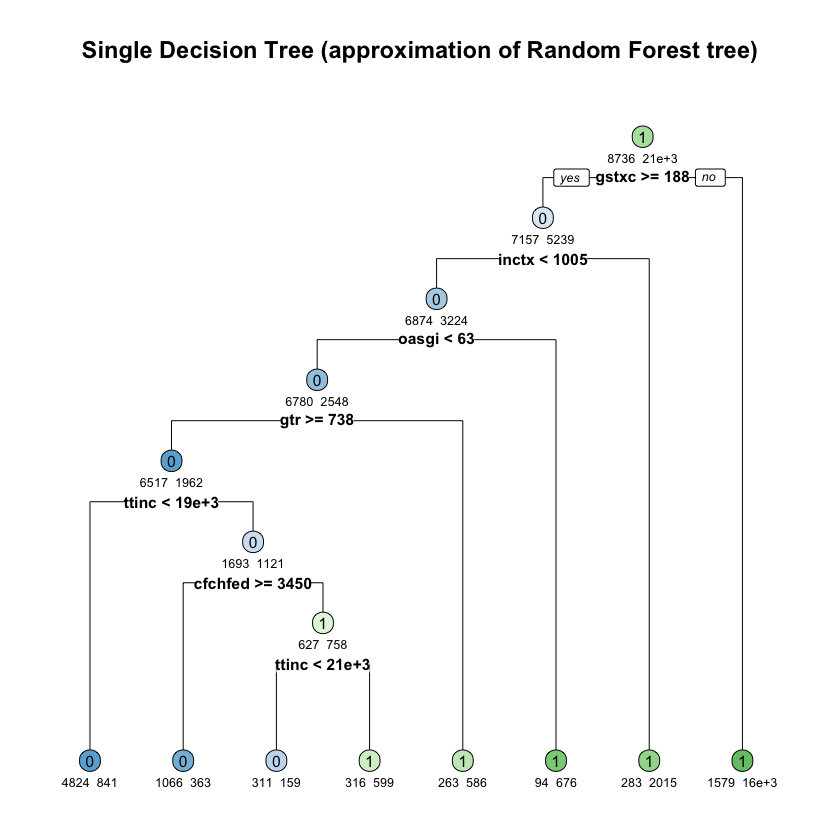

In [111]:
single_tree <- rpart(as.factor(y_train) ~ ., data = as.data.frame(X_train))

# Plot the single tree
rpart.plot(single_tree,
           main = "Single Decision Tree (approximation of Random Forest tree)",
           type = 2,  # type 2 = labels all nodes
           extra = 1, # display probability of success
           under = TRUE,
           faclen = 0)

In [112]:
### GXBoost

# Convert data to XGBoost DMatrix format
dtrain <- xgb.DMatrix(data = X_train, label = y_train)
dtest  <- xgb.DMatrix(data = X_test, label = y_test)

# Model 1: Default Parameters
xgb_model1 <- xgboost(
  data = dtrain,
  nrounds = 100,
  max_depth = 3,
  eta = 0.1,
  subsample = 1,
  objective = "binary:logistic",
  eval_metric = "logloss",
  verbose = 0
)

# Model 2: Lower Learning Rate, More Trees
xgb_model2 <- xgboost(
  data = dtrain,
  nrounds = 500,
  max_depth = 4,
  eta = 0.05,
  subsample = 0.8,
  objective = "binary:logistic",
  eval_metric = "logloss",
  verbose = 0
)

# Model 3: Deeper Trees, Fewer Rounds
xgb_model3 <- xgboost(
  data = dtrain,
  nrounds = 200,
  max_depth = 6,
  eta = 0.1,
  subsample = 0.7,
  objective = "binary:logistic",
  eval_metric = "logloss",
  verbose = 0
)

# Make predictions on the test sample (probabilities)
pred_xgb1 <- predict(xgb_model1, dtest)
pred_xgb2 <- predict(xgb_model2, dtest)
pred_xgb3 <- predict(xgb_model3, dtest)

# If you want to predict 0/1 classes (not probabilities), threshold at 0.5
pred_class_xgb1 <- ifelse(pred_xgb1 > 0.5, 1, 0)
pred_class_xgb2 <- ifelse(pred_xgb2 > 0.5, 1, 0)
pred_class_xgb3 <- ifelse(pred_xgb3 > 0.5, 1, 0)

# Compute RMSE for Each Model
rmse_xgb1 <- sqrt(mean((pred_xgb1 - y_test)^2))
rmse_xgb2 <- sqrt(mean((pred_xgb2 - y_test)^2))
rmse_xgb3 <- sqrt(mean((pred_xgb3 - y_test)^2))

cat("Test RMSE for XGBoost Model 1 (Default Parameters):", rmse_xgb1, "\n")
cat("Test RMSE for XGBoost Model 2 (Lower Learning Rate, More Trees):", rmse_xgb2, "\n")
cat("Test RMSE for XGBoost Model 3 (Deeper Trees, Fewer Rounds):", rmse_xgb3, "\n")


Test RMSE for XGBoost Model 1 (Default Parameters): 0.2795817 
Test RMSE for XGBoost Model 2 (Lower Learning Rate, More Trees): 0.2389158 
Test RMSE for XGBoost Model 3 (Deeper Trees, Fewer Rounds): 0.2292143 


In [113]:
## Create XGBoost confusion matrix

# Create a named vector of RMSEs
rmse_values <- c(
  Model1 = rmse_xgb1,
  Model2 = rmse_xgb2,
  Model3 = rmse_xgb3
)

# Find the best model (lowest RMSE)
best_model_name <- names(rmse_values)[which.min(rmse_values)]
best_rmse_value <- min(rmse_values)

# Print the best model
cat("Best XGBoost Model:", best_model_name, "with RMSE:", round(best_rmse_value, 4), "\n")

# Map the model name to the actual model object
best_xgb_model <- switch(
  best_model_name,
  Model1 = xgb_model1,
  Model2 = xgb_model2,
  Model3 = xgb_model3
)

# Predict probabilities
xgb_probs <- predict(best_xgb_model, newdata = dtest)

# Convert to class labels
xgb_preds <- ifelse(xgb_probs > 0.5, 1, 0)

# Confusion Matrix
conf_matrix_xgb <- confusionMatrix(factor(xgb_preds), factor(y_test))
print(conf_matrix_xgb)



Best XGBoost Model: Model3 with RMSE: 0.2292 
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 3209  413
         1  514 8528
                                          
               Accuracy : 0.9268          
                 95% CI : (0.9221, 0.9313)
    No Information Rate : 0.706           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8223          
                                          
 Mcnemar's Test P-Value : 0.001022        
                                          
            Sensitivity : 0.8619          
            Specificity : 0.9538          
         Pos Pred Value : 0.8860          
         Neg Pred Value : 0.9432          
             Prevalence : 0.2940          
         Detection Rate : 0.2534          
   Detection Prevalence : 0.2860          
      Balanced Accuracy : 0.9079          
                                          
       'Positive' Cla

In [ ]:
# Fit the probability forest (binary classification)
grf_model <- probability_forest(X_train, as.factor(y_train), mtry = best_mtry, num.trees = 100)

# Predict probabilities
grf_probs <- predict(grf_model, newdata = X_test)

# Extract probability of class 1
prob_1 <- grf_probs$predictions[, 2]

# Turn into a dataframe
prob_df <- data.frame(probability_of_1 = prob_1)

# Convert to class labels
grf_preds <- ifelse(prob_df > 0.5, 1, 0)

# Evaluate performance
conf_matrix <- confusionMatrix(factor(grf_preds), factor(y_test))
print(conf_matrix)

importance_grf <- variable_importance(grf_model)
var_names <- colnames(X_train)

# Put into a dataframe
grf_importance_df <- data.frame(
  Variable = var_names,
  Importance = importance_grf
)

# Plot with ggplot2
library(ggplot2)
ggplot(grf_importance_df[order(-grf_importance_df$Importance), ][1:20, ], 
       aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_col(fill = "darkgreen") +
  coord_flip() +
  labs(title = "GRF Variable Importance", x = "Variable", y = "Importance") +
  theme_minimal()

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



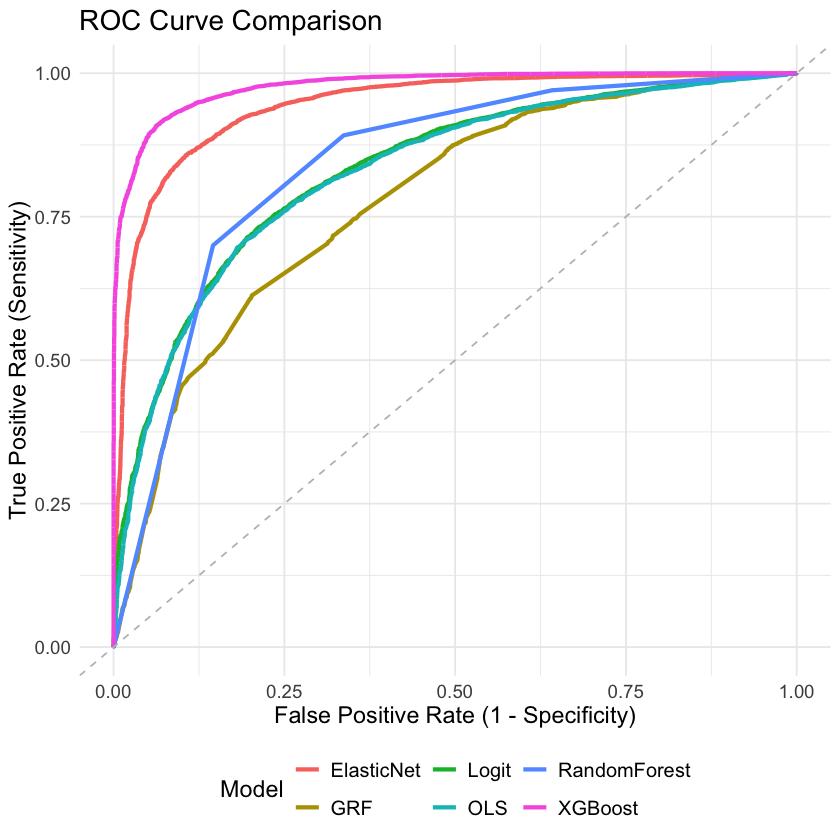

In [119]:
### Plot ROC

# Generate Probabilities for Each Model
logit_probs <- predict(logit_model, newdata = df_test, type = "response")
ols_probs <- predict(ols_model, newdata = df_test)
elastic_net_probs <- predict(cv_model, newx = X_test, type = "response", s = "lambda.min")
rf_probs <- predict(best_rf_model, newdata = X_test, type = "prob")[,2]
xgb_probs <- predict(best_xgb_model, newdata = dtest)  

# True labels
Y_test <- y_test

# Create ROC objects
roc_list <- list(
  Logit = roc(Y_test, logit_probs),
  OLS = roc(Y_test, ols_probs),
  ElasticNet = roc(Y_test, as.vector(elastic_net_probs)),
  RandomForest = roc(Y_test, rf_probs),
  XGBoost = roc(Y_test, xgb_probs),
  GRF = roc(Y_test, prob_1)
)

# Extract ROC data
roc_data <- do.call(rbind, lapply(names(roc_list), function(model_name) {
  roc_curve <- roc_list[[model_name]]
  data.frame(
    model = model_name,
    specificity = rev(roc_curve$specificities),
    sensitivity = rev(roc_curve$sensitivities)
  )
}))

# Plot ROC curves
ggplot(roc_data, aes(x = 1 - specificity, y = sensitivity, color = model)) +
  geom_line(size = 1.2) +
  geom_abline(linetype = "dashed", color = "gray") +
  labs(
    title = "ROC Curve Comparison",
    x = "False Positive Rate (1 - Specificity)",
    y = "True Positive Rate (Sensitivity)",
    color = "Model"
  ) +
  theme_minimal() +
  theme(
    text = element_text(size = 14),
    legend.position = "bottom",
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12)
  )


## **Results**